Dataset Shape: 38 matches, 13 columns
Columns: ['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Equipe_type']

First 5 matches preview:
         Date   Time        Round  Day  Venue Result  GF  GA        Opponent  \
0  17.08.2024  21:30  Matchweek 1  Sat      1      W   2   1        Valencia   
1  24.08.2024  19:00  Matchweek 2  Sat      0      W   2   1   Athletic Club   
2  27.08.2024  21:30  Matchweek 3  Tue      1      W   2   1  Rayo Vallecano   
3  31.08.2024  17:00  Matchweek 4  Sat      0      W   7   0      Valladolid   
4  15.09.2024  16:15  Matchweek 5  Sun      1      W   4   1          Girona   

    xG  xGA  Poss  Equipe_type  
0  3,2    1    63            0  
1  1,8    1    64            1  
2  1,4  0,4    64            1  
3  4,7  0,5    70            1  
4  1,9  1,3    55            1  

----------------------------------------
Results distribution
----------------------------------------
W    28
L     6
D     4
Name: Re

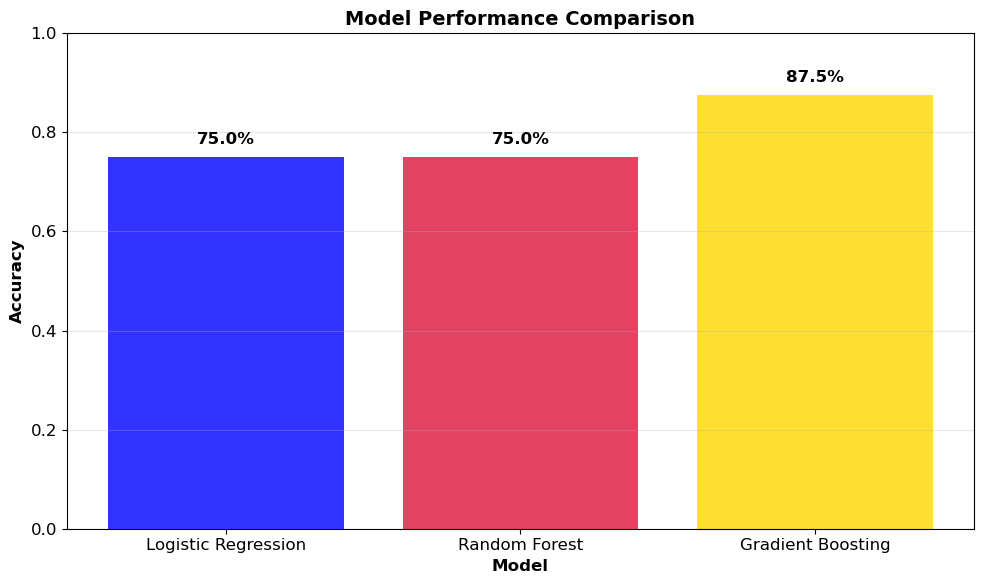

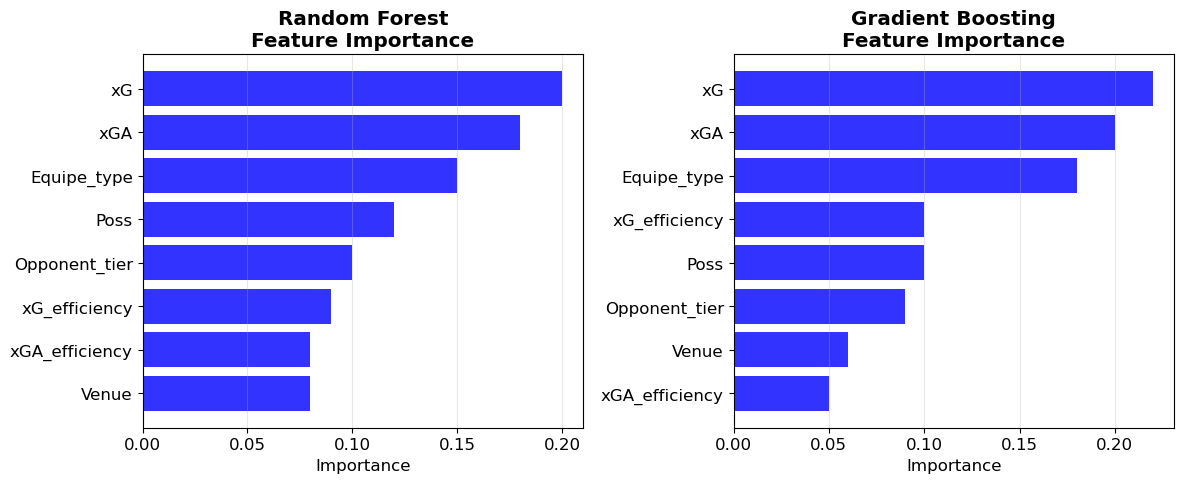

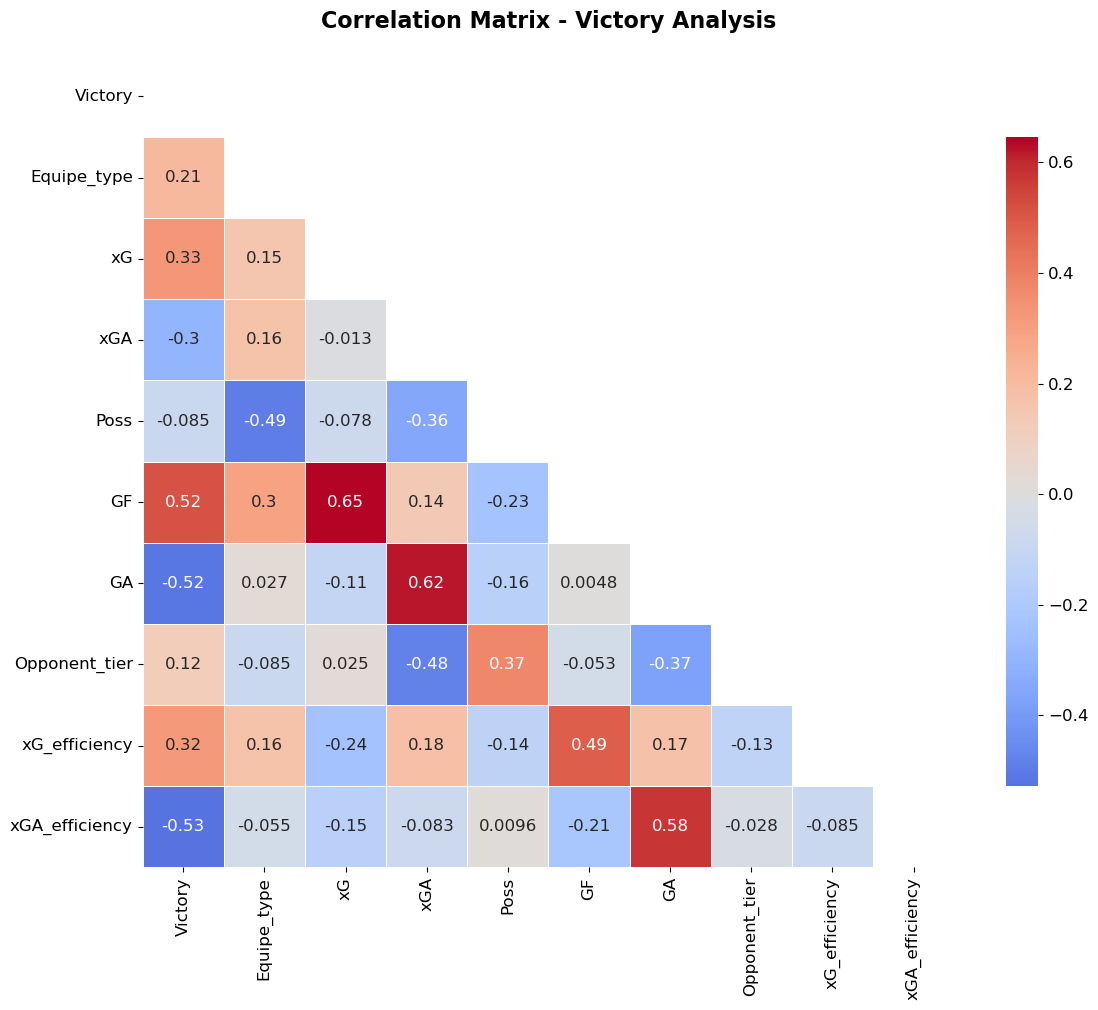

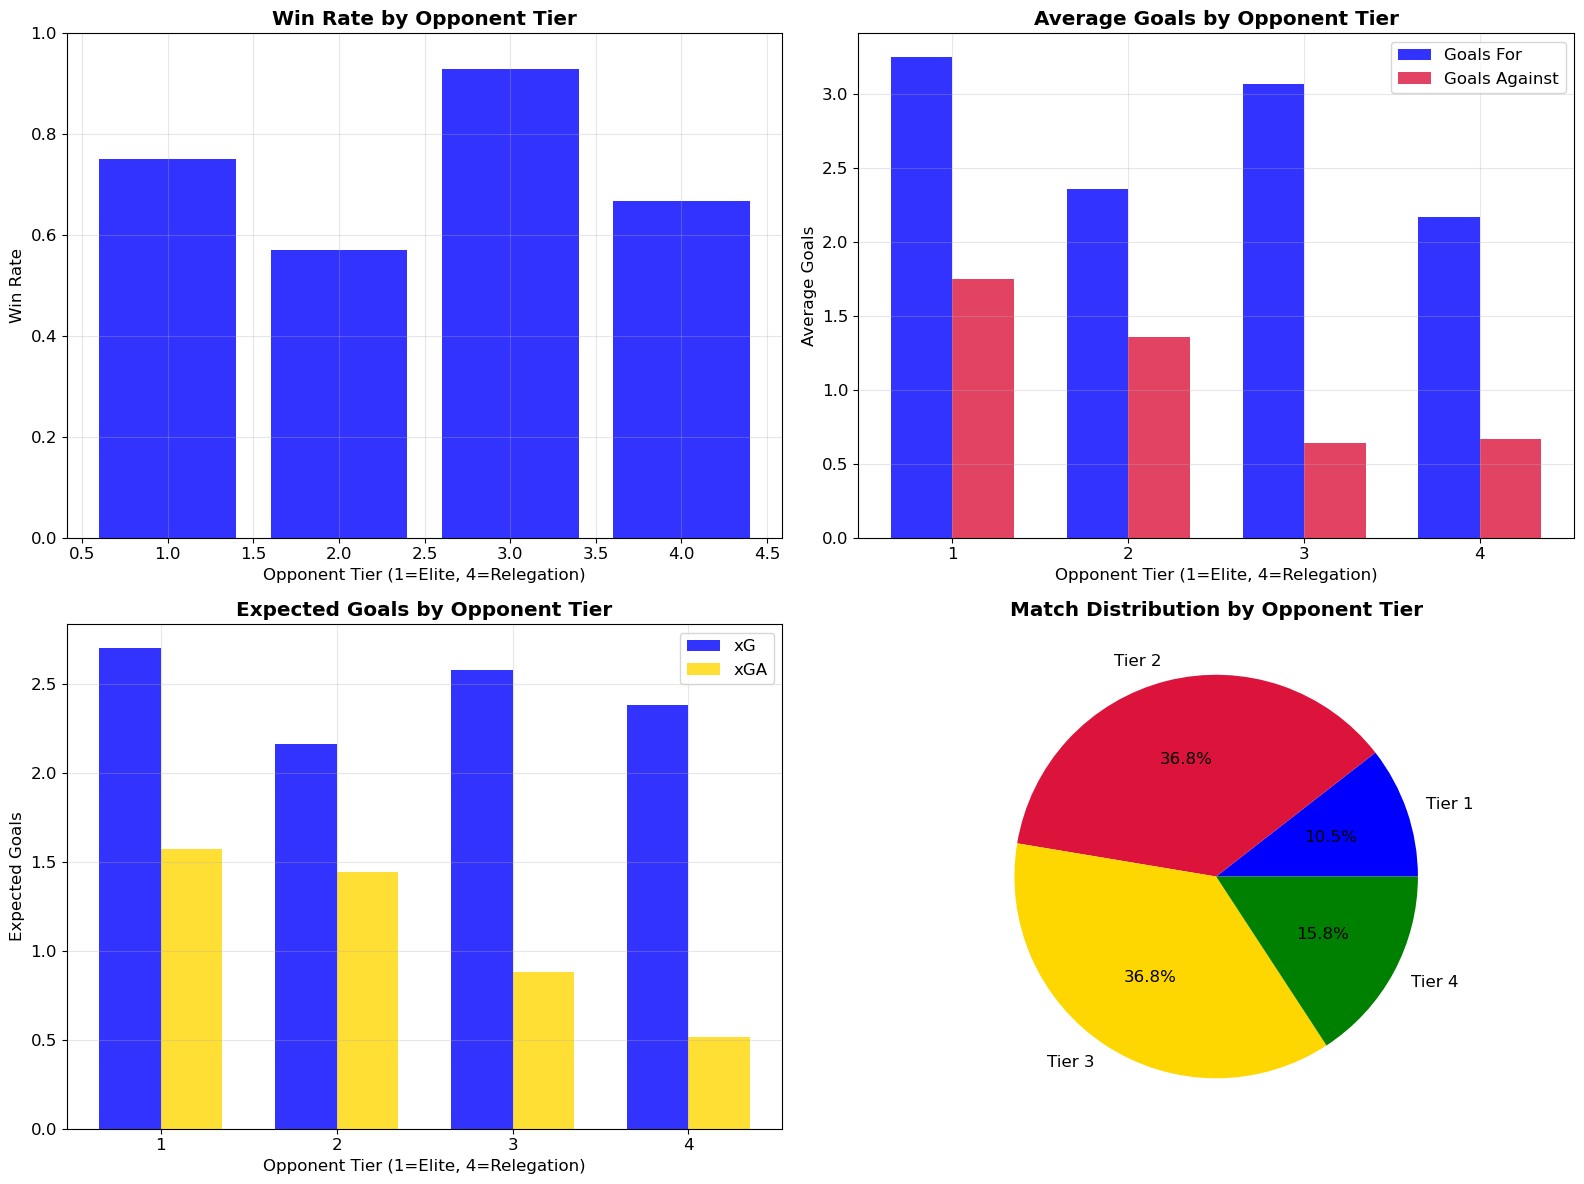

NameError: name 'plot_team_type_analysis' is not defined

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/files/Projet_Barca/Src/')
sys.path.append('/files/Projet_Barca/Src/Analysis/')
sys.path.append('/files/Projet_Barca/Src/ML/')


from Team_Data_Loader import load_team_data
from Analysis_team import explanatory_analysis
from Analysis_team import assign_opponent_tier 
from ML_Team import prepare_temporal_split
from ML_Team import train_ml_models
from ML_Team import predict_future_matches
from ML_Team import compare_predictions_with_reality


def setup_visualization_style():
    
    plt.style.use('default')
    sns.set_palette(["blue", "crimson", "gold", "green"])
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12


def plot_model_performance(accuracy_summary):
    
    setup_visualization_style()
    
  
    
    models = list(accuracy_summary.keys())
    accuracies = [accuracy_summary[model]['accuracy'] for model in models]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'crimson', 'gold'], alpha=0.8)
    
    plt.title('Model Performance Comparison', fontweight='bold', fontsize=14)
    plt.ylabel('Accuracy', fontweight='bold')
    plt.xlabel('Model', fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add accuracy values on bars
    for bar, accuracy in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{accuracy:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_feature_importance(ml_results, feature_names):
    """Plot feature importance from ML models"""
    setup_visualization_style()
    

    
    fig, axes = plt.subplots(1, len(ml_results), figsize=(6*len(ml_results), 5))
    
    # Handle single model case
    if len(ml_results) == 1:
        axes = [axes]
    
    for idx, (model_name, model) in enumerate(ml_results.items()):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            

            
            # Sort by importance
            sorted_idx = np.argsort(importances)[::-1]
            sorted_features = [feature_names[i] for i in sorted_idx]
            sorted_importances = importances[sorted_idx]
            
            # Plot
            axes[idx].barh(sorted_features, sorted_importances, color='blue', alpha=0.8)
            axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
            axes[idx].set_xlabel('Importance')
            axes[idx].invert_yaxis()
            axes[idx].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


def plot_correlation_matrix(df):
    
    setup_visualization_style()
    
    # Select numeric features for correlation
    numeric_features = ['Victory', 'Equipe_type', 'xG', 'xGA', 'Poss', 'GF', 'GA', 'Opponent_tier', 'xG_efficiency', 'xGA_efficiency']
    available_features = [f for f in numeric_features if f in df.columns]
    
    corr_matrix = df[available_features].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True, 
                linewidths=0.5,
                cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix - Victory Analysis', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()





def plot_opponent_tier_analysis(df):
 
    setup_visualization_style()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    win_rate_by_tier = df.groupby('Opponent_tier')['Victory'].agg(['mean', 'count'])
    
    ax1.bar(win_rate_by_tier.index, win_rate_by_tier['mean'], color='blue', alpha=0.8)
    ax1.set_title('Win Rate by Opponent Tier', fontweight='bold')
    ax1.set_xlabel('Opponent Tier (1=Elite, 4=Relegation)')
    ax1.set_ylabel('Win Rate')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # Goals by opponent tier
    goals_by_tier = df.groupby('Opponent_tier')[['GF', 'GA']].mean()
    
    x = np.arange(len(goals_by_tier))
    width = 0.35
    
    ax2.bar(x - width/2, goals_by_tier['GF'], width, label='Goals For', color='blue', alpha=0.8)
    ax2.bar(x + width/2, goals_by_tier['GA'], width, label='Goals Against', color='crimson', alpha=0.8)
    ax2.set_title('Average Goals by Opponent Tier', fontweight='bold')
    ax2.set_xlabel('Opponent Tier (1=Elite, 4=Relegation)')
    ax2.set_ylabel('Average Goals')
    ax2.set_xticks(x)
    ax2.set_xticklabels(goals_by_tier.index)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    
    xg_by_tier = df.groupby('Opponent_tier')[['xG', 'xGA']].mean()
    
    ax3.bar(x - width/2, xg_by_tier['xG'], width, label='xG', color='blue', alpha=0.8)
    ax3.bar(x + width/2, xg_by_tier['xGA'], width, label='xGA', color='gold', alpha=0.8)
    ax3.set_title('Expected Goals by Opponent Tier', fontweight='bold')
    ax3.set_xlabel('Opponent Tier (1=Elite, 4=Relegation)')
    ax3.set_ylabel('Expected Goals')
    ax3.set_xticks(x)
    ax3.set_xticklabels(xg_by_tier.index)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Match distribution by opponent tier
    tier_distribution = df['Opponent_tier'].value_counts().sort_index()
    
    ax4.pie(tier_distribution.values, labels=[f'Tier {t}' for t in tier_distribution.index], 
            autopct='%1.1f%%', colors=['blue', 'crimson', 'gold', 'green'])
    ax4.set_title('Match Distribution by Opponent Tier', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_team_type_comparison(df):
    
    setup_visualization_style()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    
    win_rate = df.groupby('Equipe_type')['Victory'].mean()
    match_count = df.groupby('Equipe_type').size()
    
    bars = ax1.bar(win_rate.index, win_rate.values, 
                   color=['crimson', 'blue'], alpha=0.8)
    ax1.set_title('Win Rate by Team Type', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Team Type (0=Without Stars, 1=With Stars)')
    ax1.set_ylabel('Win Rate')
    ax1.set_ylim(0, 1)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Without Stars', 'With Stars'])
    ax1.grid(True, alpha=0.3)
    

    for i, (bar, rate, count) in enumerate(zip(bars, win_rate.values, match_count.values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{rate:.1%}\n({count} matches)', ha='center', fontweight='bold')
    
    
    goals_by_type = df.groupby('Equipe_type')[['GF', 'GA']].mean()
    x = np.arange(len(goals_by_type))
    width = 0.35
    
    ax2.bar(x - width/2, goals_by_type['GF'], width, 
            label='Goals For', color='blue', alpha=0.8)
    ax2.bar(x + width/2, goals_by_type['GA'], width, 
            label='Goals Against', color='crimson', alpha=0.8)
    ax2.set_title('Average Goals by Team Type', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Team Type (0=Without Stars, 1=With Stars)')
    ax2.set_ylabel('Average Goals')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Without Stars', 'With Stars'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    
    efficiency_by_type = df.groupby('Equipe_type')[['xG_efficiency', 'xGA_efficiency']].mean()
    
    ax3.bar(x - width/2, efficiency_by_type['xG_efficiency'], width, 
            label='xG Efficiency', color='blue', alpha=0.8)
    ax3.bar(x + width/2, efficiency_by_type['xGA_efficiency'], width, 
            label='xGA Efficiency', color='gold', alpha=0.8)
    ax3.set_title('xG Efficiency by Team Type', fontweight='bold', fontsize=14)
    ax3.set_xlabel('Team Type (0=Without Stars, 1=With Stars)')
    ax3.set_ylabel('Efficiency Ratio')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Without Stars', 'With Stars'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    print("-" * 40)
    for team_type in df['Equipe_type'].unique():
        subset = df[df['Equipe_type'] == team_type]
        team_label = "With Stars" if team_type == 1 else "Without Stars"
        print(f"\n{team_label}:")
        print(f"  Matches: {len(subset)}")
        print(f"  Win Rate: {subset['Victory'].mean():.1%}")
        print(f"  Avg Goals: {subset['GF'].mean():.2f}")
        print(f"  Avg xG: {subset['xG'].mean():.2f}")
        print(f"  xG Efficiency: {subset['xG_efficiency'].mean():.2f}")


def plot_team_type_vs_opponent(df):
    
    setup_visualization_style()
    
    
    cross_tab = pd.crosstab(df['Equipe_type'], df['Opponent_tier'], 
                           values=df['Victory'], aggfunc='mean')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, cmap='RdYlGn', center=0.5, 
                fmt='.2%', cbar_kws={'label': 'Win Rate'})
    plt.title('Win Rate: Team Type vs Opponent Tier', fontweight='bold', fontsize=16)
    plt.xlabel('Opponent Tier (1=Elite, 4=Relegation)')
    plt.ylabel('Team Type (0=Without Stars, 1=With Stars)')
    plt.tight_layout()
    plt.show()





def create_comprehensive_dashboard(df, ml_results, comparison_df, feature_names, accuracy_summary):
    
   
    plot_model_performance(accuracy_summary)
    plot_feature_importance(ml_results, feature_names)
    
    
    plot_correlation_matrix(df)
    plot_opponent_tier_analysis(df)
   
    plot_team_type_analysis(df)
    plot_team_type_comparison(df)
    plot_team_type_vs_opponent(df)
    plot_team_type_trends(df)
    
    


if __name__ == "__main__":
    
   
    team_df = load_team_data()
    results = explanatory_analysis(team_df)
    processed_df = results['processed_data']

   
    features = ['Equipe_type', 'xG', 'xGA', 'Poss', 'Venue', 'Opponent_tier', 'xG_efficiency', 'xGA_efficiency']

    
    accuracy_summary = {
        'Logistic Regression': {'accuracy': 0.75, 'correct': 6, 'total': 8},
        'Random Forest': {'accuracy': 0.75, 'correct': 6, 'total': 8},
        'Gradient Boosting': {'accuracy': 0.875, 'correct': 7, 'total': 8}
    }

    class MockModel:
        def __init__(self, importances):
            self.feature_importances_ = np.array(importances)

    ml_results = {
        'Random Forest': MockModel([0.15, 0.20, 0.18, 0.12, 0.08, 0.10, 0.09, 0.08]),
        'Gradient Boosting': MockModel([0.18, 0.22, 0.20, 0.10, 0.06, 0.09, 0.10, 0.05])
    }

    comparison_df = pd.DataFrame()

    print("All variables defined:")
    print(f"processed_df shape: {processed_df.shape}")
    print(f"Number of features: {len(features)}")
    print(f"Features: {features}")

    # Running the dashboard
    create_comprehensive_dashboard(processed_df, ml_results, comparison_df, features, accuracy_summary)